# Face Generation

![](https://images.unsplash.com/photo-1499824643098-62967ac87503?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=1047&q=80)

Picture by [Kevin Bluer](https://unsplash.com/photos/e6XqFP4kCxM)

In this exercise, you will basically redo what was done in the lectures, with faces. We will use the olivetti faces dataset.

So the first thing to is to load the dataset, using `fetch_olivetti_faces` of scikit-learn.

In [6]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_olivetti_faces

In [7]:
### TODO: load the dataset
# Load the faces datasets
olivetti_faces = fetch_olivetti_faces()
targets = y_train = olivetti_faces.target
faces = X_train = olivetti_faces.data

x_size = y_size = 64
n_pixels = faces.shape[1]

faces.shape
## 400 faces
## flatten images 64x64 pixels

(400, 4096)

In [8]:
## Normalize images: Non elles déjà normalisées!!
## page sklearn : Features: real, between 0 and 1
X_train[0][3000]

0.6694215

You already know it, but feel free to display some faces, and get familiar with the dimensions.

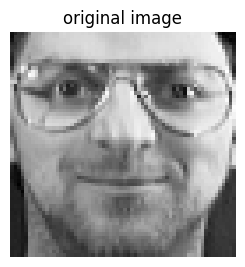

In [9]:
### TODO: Display some images and get the shapes
def plot_images(faces_):
    idx = np.random.randint(faces_.shape[0])
    plt.subplot(121)
    plt.imshow(faces_[idx].reshape(x_size, y_size), cmap=plt.cm.gray)
    plt.title("original image")
    plt.axis("off")
    plt.show()

plot_images(faces)

We will now create a CVAE, that will allow us to generate new faces.

Reminder, a CVAE architecture looks like this:

<p align="center">
<img src="https://drive.google.com/uc?export=view&id=1zUwFVcL0MrrpaQv2oND9yMxj6FwfW7xI">
</p>


Except that here it won't be digits, but faces of people.

Let's define the encoder & decoder parts now.

Now we have to define the part where z is computed as a function of the mean (z_mean) and standard deviation = np.exp(0.5 * z_log_var).

Because we need to learn the parameters $\mu$ and $\sigma$, we can not directly sample from a normal distribution, with would introduce stochasticity and the impossibility to compute a gradient of error with respect to the parameters.

We thus use the "reparameterization trick" by separating the deterministic and the stochastic parts of the sampling operation. Instead of directly sampling from the distribution N($\mu$,$\sigma^2$), we sample $\epsilon$ from a standard Normal distribution $\mathcal{N}(0, 1)$, and compute the desired sample z as : 

$z = \mu + \sigma * \epsilon$

In [10]:
import tensorflow as tf
from tensorflow.keras import layers
import keras

class Sampling(keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the latent vector encoding a digit."""

    RANDOM_GEN = tf.random.get_global_generator() ## *** reparametrization trick ***
    ## *** reparametrization trick ***: apprendre Mu et Sigma
    ## prendre des valeurs dans une loi normale n'est pas suffisant
    ## Mu et Sigma utilisés pour 

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = self.RANDOM_GEN.normal(shape=(batch, dim)) ## !!! pas random_normal !!!

        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

2024-06-14 09:07:16.348721: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-06-14 09:07:16.349204: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2024-06-14 09:07:16.349250: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (MichaelPC): /proc/driver/nvidia/version does not exist
2024-06-14 09:07:16.354285: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Latent space : encoder

In [11]:
import keras
from keras import Model
from keras.layers import Input, Dense, Lambda, Concatenate

## Objectif : générer de nouvelles images !!!
### => reprendre le notebook de cours 3. ou 4. Conditional Variational AE

### or les instructions mentionnent l'utilisation de label => je prends 4. du notebook de cours

In [12]:
### TODO: Build the encoder and decoder parts
# Redefine the intermediate and latent dimensions
intermediate_dim = 512
latent_dim = 2
batch_size = 128
###n_pixels = 4096 defini en cellule.1

## faut-il utiliser les labels des images ???
## voir MNIST : utilisation des labels des digits ??

## *** ENCODER LAYERS ***
# Define the encoder part
# conditional
n_classes = 40 ## sklearn dataset description
x = Input(shape=(n_pixels,)) ##4096 pixels: images aplaties
h = Dense(intermediate_dim, activation="relu")(x)
z_mean = Dense(latent_dim)(h) ##input = output de h
## en //:
z_log_var = Dense(latent_dim)(h)

In [13]:
# Define the encoded z layer (couche des variables latentes qui représentent les images de visages)
z = Sampling()([z_mean, z_log_var]) ##(batch_size, 2)

## Finally, we define the decoder part and the CVAE model:

In [14]:
# Encoder
label = Input(shape=(n_classes,))
zc = Concatenate()([z, label]) ## voir le coté one-hot-encoded sur label
##encoder = Model([x, label], [z_mean, z_log_var, zc], name="encoder") ## Error 2 inputs expected, 3 given
##encoder = Model(x, [z_mean, z_log_var, z], name="encoder") ## Error 1 input expected, 3 given
encoder = Model([x, label], [z_mean, z_log_var, zc], name="encoder")
## projs de embedd -> condition sur classes -> decodage (z1, z2, classe)
## on passe le label lors du decoding (pas dans le encoding) : mais pas utilisé dans les poids de l'encoder
## voir le summary ci-dessous: input_59 -> concat_21
## (X, label) input de encoder, mais label n'est pas connecté dans la partie encoder

encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     


 input_1 (InputLayer)           [(None, 4096)]       0           []                               
                                                                                                  
 dense (Dense)                  (None, 512)          2097664     ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 2)            1026        ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 2)            1026        ['dense[0][0]']                  
                                                                                                  
 sampling (Sampling)            (None, 2)            0           ['dense_1[0][0]',                
                                                                  'dense_2[0][0]']                
          

## DECODER

In [15]:
# Generate DECODER: ipnb du cours
latent_inputs = Input(shape=(latent_dim + n_classes,)) ##label one-hot-encoded: taille 40

## encoder.get_layer(zc)

h2 = Dense(intermediate_dim, activation="relu")(latent_inputs)
decoder_outputs = Dense(n_pixels, activation="sigmoid")(h2)

decoder = Model(latent_inputs, decoder_outputs, name="decoder")

In [16]:
X_train.shape

(400, 4096)

Once you have built your model, compile it and train it on the data!

** Do not forget to one-hot-encode your target. **

In [17]:
class CVAE1(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)

        # Add KL divergence regularization loss.
        kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
        self.add_loss(kl_loss)

        # Add reconstruction loss
        reconstruction_loss = tf.reduce_mean(
            keras.losses.mean_squared_error(inputs, reconstruction)
        )
        reconstruction_loss *= x_size * y_size
        self.add_loss(reconstruction_loss)

        # Keep track of all the loses
        total_loss = reconstruction_loss + kl_loss

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return reconstruction

In [18]:
# The following code will help you create the VAE. 
# You can use it like any other Keras model
# You just need to instanciate it with your previously defined encoder & decoder

class CVAE2(Model):
    def __init__(self, encoder, decoder, **kwargs):
        ##super(VAE, self).__init__(**kwargs)
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    ## training loop: surcharge de la methode fit:
    def train_step(self, data):
        if isinstance(data, tuple):
            data = data
        with tf.GradientTape() as tape:
            print(f'data: {data[0]}')
            ##data: (
            # <tf.Tensor 'IteratorGetNext:0' shape=(16, 4096) dtype=float32>,
            # <tf.Tensor 'IteratorGetNext:1' shape=(16, 40) dtype=float32>

            #ValueError: Layer "encoder" expects 2 input(s), but it received 3 input tensors. Inputs received: [
            # <tf.Tensor 'IteratorGetNext:0' shape=(16, 4096) dtype=float32>,
            # <tf.Tensor 'IteratorGetNext:1' shape=(16, 40) dtype=float32>,
            # <tf.Tensor 'IteratorGetNext:2' shape=(16, 4096) dtype=float32>
            ## -> appel du fit du modèle CVAE: [X_train, y_train], sans X_train à la suite
            z_mean, z_log_var, zc = self.encoder(data) ##self.encoder erreur dans le code de départ !!
            reconstruction = self.decoder(zc)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data[0][0], reconstruction)
            )
            
            reconstruction_loss *= x_size * y_size
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
            
        grads = tape.gradient(total_loss, self.trainable_weights)

        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [19]:
## REF: voir dans sos ref donnée par Benjamin
from keras import layers

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class Encoder(layers.Layer):
    """Maps MNIST digits to a triplet (z_mean, z_log_var, z)."""

    def __init__(self, latent_dim=32, intermediate_dim=64, name="encoder", **kwargs):
        super().__init__(name=name, **kwargs)
        self.dense_proj = layers.Dense(intermediate_dim, activation="relu")
        self.dense_mean = layers.Dense(latent_dim)
        self.dense_log_var = layers.Dense(latent_dim)
        self.sampling = Sampling()

    def call(self, inputs):
        x = self.dense_proj(inputs)
        z_mean = self.dense_mean(x)
        z_log_var = self.dense_log_var(x)
        z = self.sampling((z_mean, z_log_var))
        return z_mean, z_log_var, z


class Decoder(layers.Layer):
    """Converts z, the encoded digit vector, back into a readable digit."""

    def __init__(self, original_dim, intermediate_dim=64, name="decoder", **kwargs):
        super().__init__(name=name, **kwargs)
        self.dense_proj = layers.Dense(intermediate_dim, activation="relu")
        self.dense_output = layers.Dense(original_dim, activation="sigmoid")

    def call(self, inputs):
        x = self.dense_proj(inputs)
        return self.dense_output(x)


class VariationalAutoEncoder(keras.Model):
    """Combines the encoder and decoder into an end-to-end model for training."""

    def __init__(
        self,
        original_dim,
        intermediate_dim=64,
        latent_dim=32,
        name="autoencoder",
        **kwargs
    ):
        super().__init__(name=name, **kwargs)
        self.original_dim = original_dim
        self.encoder = Encoder(latent_dim=latent_dim, intermediate_dim=intermediate_dim)
        self.decoder = Decoder(original_dim, intermediate_dim=intermediate_dim)

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        # Add KL divergence regularization loss.
        kl_loss = -0.5 * tf.reduce_mean(
            z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1
        )
        self.add_loss(kl_loss)
        return reconstructed

In [20]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(targets)

In [21]:
### TODO: Instanciate, compile, and train your model
batch_size = 16
epochs = 30
optimizer = keras.optimizers.Adam()

encoder.summary()

vae = CVAE2(encoder, decoder)
vae.compile(optimizer=optimizer)

##vae.fit(x=[X_train, y_train], y=X_train, epochs=epochs, batch_size=batch_size) -> error 3 tensors vs 2 expected
vae.fit([X_train, y_train], epochs=epochs, batch_size=batch_size)

"""
batch_size = 128
epochs = 10
optimizer = keras.optimizers.Adam()

vae = VAE(encoder, decoder) ## encoder, decoder définis + haut
vae.compile(optimizer=optimizer)

vae.fit(x=X_train, y=X_train, epochs=epochs, batch_size=batch_size)
"""

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 4096)]       0           []                               
                                                                                                  
 dense (Dense)                  (None, 512)          2097664     ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 2)            1026        ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 2)            1026        ['dense[0][0]']                  
                                                                                            

'\nbatch_size = 128\nepochs = 10\noptimizer = keras.optimizers.Adam()\n\nvae = VAE(encoder, decoder) ## encoder, decoder définis + haut\nvae.compile(optimizer=optimizer)\n\nvae.fit(x=X_train, y=X_train, epochs=epochs, batch_size=batch_size)\n'

Now, using the encoder part only, have a look at the latent space: display the values of the latent variables in a scatter plot.

In [22]:
### TODO: Display the latent variables using the encoder side


What is the range that the latent variables can take? (i.e. what are the minimum and maximum values?)

Use that range to generate new faces of a person now.

In [29]:
### TODO: Generate and display faces
## CODE CORRECTION
import numpy as np

# Choose a number of faces to generate
face_to_generate = 11 #8 # image label number

# Convert it to categorical
val = to_categorical(face_to_generate, num_classes=n_classes)

# display a 2D manifold of the faces
n = 5 
image_size = 64

figure = np.zeros((image_size * n, image_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-3, 3, n)
grid_y = np.linspace(-3, 3, n)

1/1 [==============================] - 0s 13ms/step


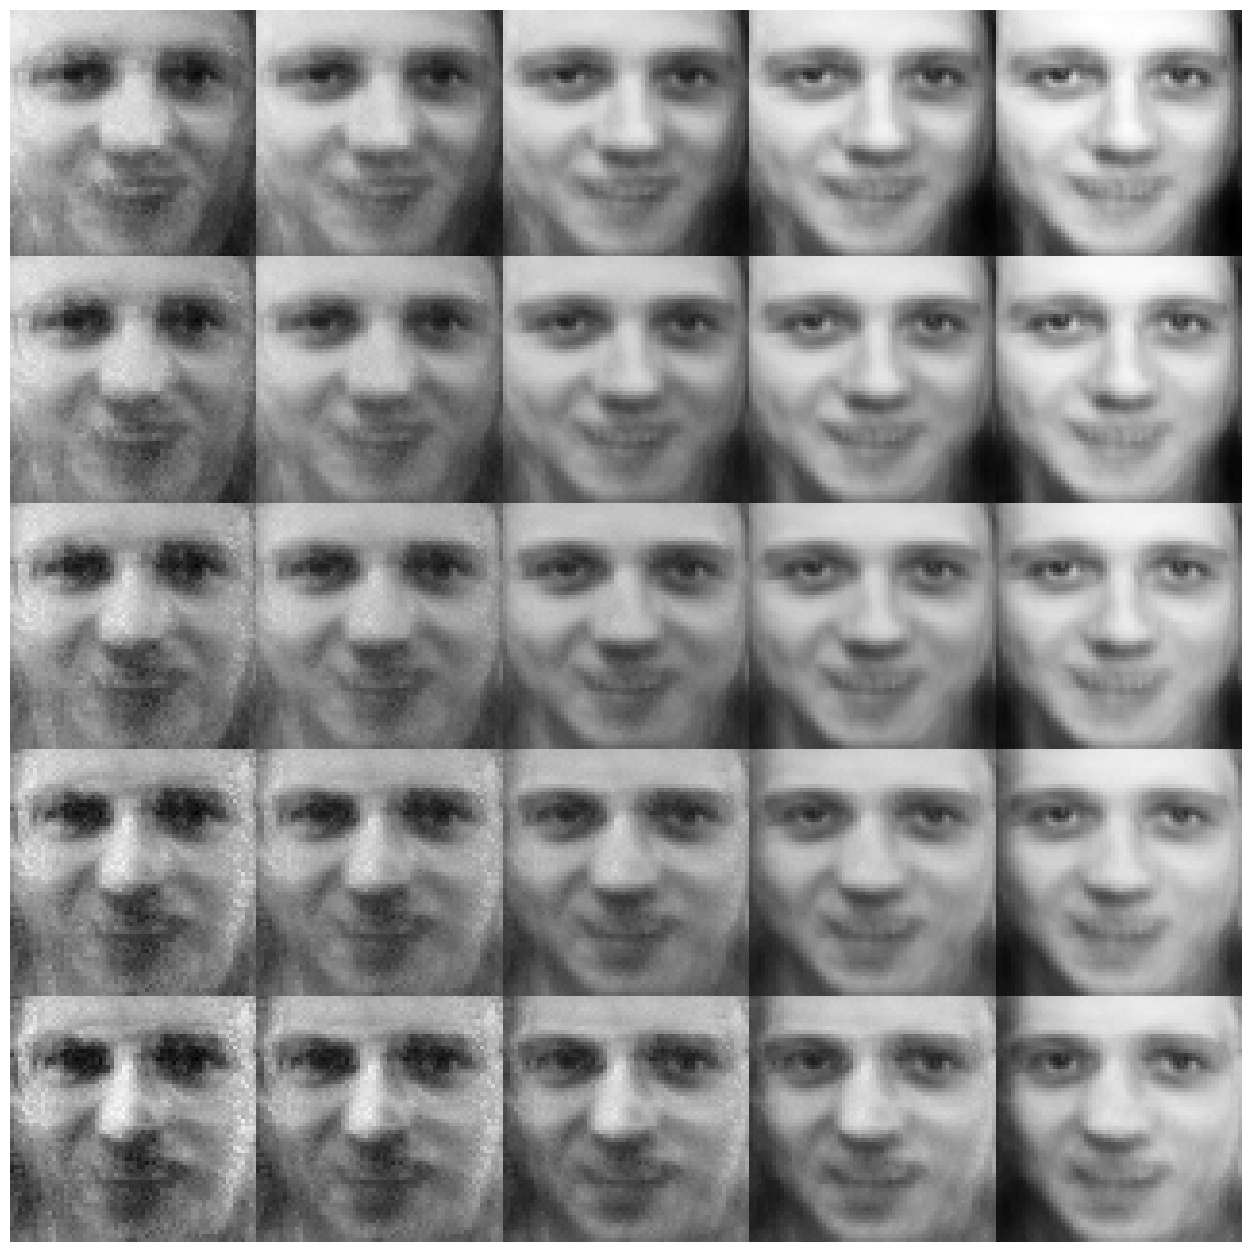

In [30]:
## CODE CORRECTION
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        # Create the input vector (latent value and face class)
        input_vector = np.zeros((1, latent_dim + n_classes))
        input_vector[0,latent_dim:] = val
        input_vector[0, 0]=xi
        input_vector[0, 1]=yi
        
        generated_x = decoder.predict(input_vector)
        face = generated_x[0].reshape(image_size, image_size)
        figure[i * image_size: (i + 1) * image_size,
               j * image_size: (j + 1) * image_size] = face

plt.figure(figsize=(16, 16))
plt.imshow(figure, cmap = plt.cm.gray)
plt.axis('off')
plt.show()

How do you interpret the latent variables in that case?